In [43]:
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [32]:
states = np.array([[0,0,0,0],   # 0
                   [0,0,0,1],   # 1
                   [0,0,1,0],   # 2
                   [0,0,1,1],   # 3
                   [0,1,0,0],   # 4
                   [0,1,0,1],   # 5
                   [0,1,1,0],   # 6
                   [0,1,1,1],   # 7
                   [1,0,0,0],   # 8
                   [1,0,0,1],   # 9
                   [1,0,1,0],   # 10
                   [1,0,1,1],   # 11
                   [1,1,0,0],   # 12
                   [1,1,0,1],   # 13
                   [1,1,1,0],   # 14
                   [1,1,1,1]])  # 15

num_states = states.shape[0]

actions = np.array([[0,0,0,0],  # 0
                    [0,1,0,0],  # 1
                    [0,0,1,0],  # 2
                    [0,0,0,1]]) # 3

# actions = np.array([[0,0,0,0],  # 0
#                     [1,0,0,0],  # 1
#                     [0,1,0,0],  # 2
#                     [0,0,1,0],  # 3
#                     [0,0,0,1]]) # 4

num_actions = actions.shape[0]

connectivity_matrix = \
    np.array([[0,0,-1,0],
              [1,0,-1,-1],
              [0,1,0,0],
              [-1,1,1,0],])

def normalize(v):
    v[v < 0] = 0
    v[v > 0] = 1

    return v

def getNextState(state, action, noise):
    cm_s = np.dot(connectivity_matrix, state)
    # print(cm_s)
    cm_s = normalize(cm_s)
    # print(cm_s)

    next_state = np.logical_xor(cm_s, action)
    # print(next_state)
    next_state = np.logical_xor(next_state, noise)
    # print(next_state)

    index = np.where(np.all(states == next_state[0], axis=1))[0][0]
    
    return index


# Calculate the reward for a given state and action
def getReward(state_index,action_index):
    # Reward is the sum of the state values (gene activation) multiplied by 5
    reward =  np.sum(states[state_index]*5)

    # Reward -1 for actions 1 and 2
    if action_index in (1,2):
        reward += -1
    
    return reward


# Calculate the noise for a given probability
def getNoise(prob):
    return np.random.binomial(n=1,p=prob,size=4)


def getTransitionProbabilities(prob):
    p = np.zeros((num_actions,num_states,num_states))
    r = np.zeros((num_actions,num_states,num_states))
    
    for a in range(num_actions):
        for i in range(num_states):
            for j in range(num_states):
                power_var = np.linalg.norm(states[j]-np.logical_xor(normalize(np.dot(connectivity_matrix, states[i])), actions[a]),ord=1)
                
                p[a][i][j] = (prob**power_var) * ((1-prob)**(4-power_var))
                r[a][i][j] = getReward(j,a)
    return p,r



In [33]:
prob    = 0.05
gamma   = 0.95
alpha   = 0.2
epsilon = 0.1
beta    = 0.05

num_episodes = 500
num_steps = 500
num_runs = 10

terminalState = 0

p,r = getTransitionProbabilities(prob)


## Q-Learning

In [55]:
# Method to get the action based on epsilon greedy policy
def getAction(s,q):
    if(np.random.random() < epsilon):
        return np.random.randint(low=0,high=num_actions,size=1)[0]
    else:
        return np.argmax(q[s])

def qlearning():
    q = np.zeros((num_states,num_actions))

    total_reward = np.zeros((num_runs,num_episodes))
    avg_reward = np.zeros((num_episodes))

    # Q Learning Algorithm
    for n in range(num_runs):
        # Initialize Q table    
        q = np.zeros((num_states,num_actions))

        for e in range(num_episodes):
        # Select random state
            s = random.randint(0,num_states-1)

            step = 0
            episode_reward = 0

            for step in range(num_steps):
                # Select action based on epsilon greedy policy
                a = getAction(s,q)

                # Get the next state using the selected action
                s_prime = getNextState(s, a, getNoise(prob))

                # Update the Q table
                q[s][a] = q[s][a] + alpha*(r[a][s][s_prime] + (gamma*np.max(q[s_prime])) - q[s][a])
                episode_reward += r[a][s][s_prime]

                # print(f'State: {s} Action: {a} Next State: {s_prime} Reward: {r[a][s][s_prime]}')

                s = s_prime
                
                # step += 1
                # if s == terminalState:
                #     break
                # else:
                #     step += 1

            # print(f'Episode: {e} Start: {begin} Step: {step} Reward: {episode_reward/step}')
            total_reward[n][e] = episode_reward
        
        policy = generate_optimal_policy(q)
        print(f'Run: {n+1} - Policy: {policy}')
    
    avg_reward = total_reward.mean(axis=0)
    return q,avg_reward

def generate_optimal_policy(Q_table):
    policy = np.zeros((num_states), dtype=int)

    for state in range(num_states):
        policy[state] = np.argmax(Q_table[state])+1

    return policy

def drawAverageAccumulativeReward(avg_reward_sarsa):
    fig = plt.subplots(figsize=(10, 5))
    sns.lineplot(data=avg_reward_sarsa, color='purple')
    sns.set_theme(style='darkgrid',font_scale=1)
    # plt.plot(avg_reward_sarsa)
    plt.xlabel('Steps')
    plt.ylabel('Average Accumulative Reward')
    # plt.legend(['$\epsilon$ = 0.0', '$\epsilon$ = 0.1', '$\epsilon$ = 0.2', '$\epsilon$ = 0.5'], loc ="lower right")
    # plt.show()





In [ ]:
q_qlearning, avg_reward_qlearning = qlearning()

# print(q_qlearning)

optimal_policy = generate_optimal_policy(q_qlearning)

print(f'\nOptimal Policy:')
print(optimal_policy)

Text(0.5, 1.0, 'Average Accumulative Reward for Q-Learning (10 Runs)')

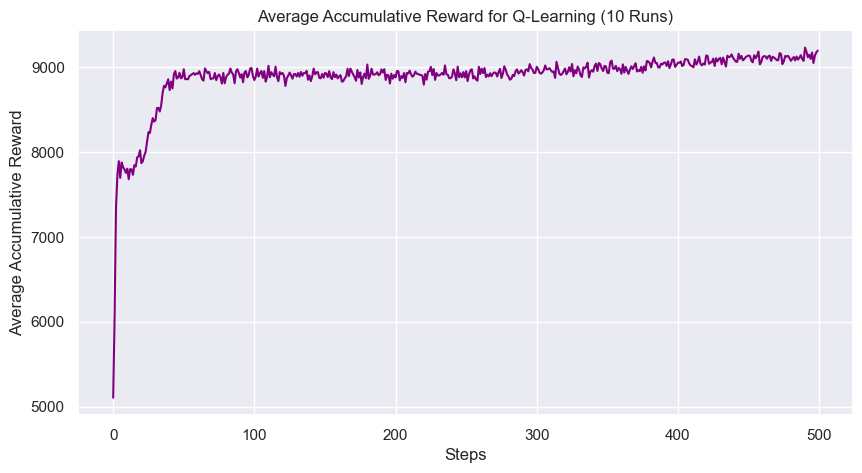

In [58]:
drawAverageAccumulativeReward(avg_reward_qlearning)
plt.title('Average Accumulative Reward for Q-Learning (10 Runs)')

# SARSA

In [36]:
def SARSA(runs, episodes, steps, alpha, gamma):
    q = np.zeros((num_states,num_actions))

    total_reward = np.zeros((runs,episodes))
    avg_reward = np.zeros((episodes))
        
    for n in range(runs):
        # Initialize Q table    
        q = np.zeros((num_states,num_actions))
        
        # SARSA Learning Algorithm
        for e in range(episodes):
            # Select random state
            s = random.randint(0,num_states-1)

            step = 0
            episode_reward = 0

            # Select action based on epsilon greedy policy
            a = getAction(s,q)
            
            while step < steps:
                s_prime = getNextState(s,a,getNoise(prob))

                # Select action based on epsilon greedy policy
                a_prime = getAction(s_prime,q)

                q[s][a] = q[s][a] + alpha*(r[a][s][s_prime] + (gamma*q[s_prime][a_prime]) - q[s][a])
                episode_reward += r[a][s][s_prime]
                
                s = s_prime
                a = a_prime

                step += 1
            
            total_reward[n][e] = episode_reward
        
        policy = generate_optimal_policy(q)
        print(f'Run: {n+1} - Policy: {policy}')

    avg_reward = total_reward.mean(axis=0)

    optimal_policy = generate_optimal_policy(q)

    return q, avg_reward, optimal_policy

In [63]:
q_sarsa, avg_reward_sarsa, optimal_policy = SARSA(runs=num_runs, episodes=num_episodes, steps=num_steps, alpha=alpha, gamma=gamma)

Run: 1 - Policy: [3 3 4 4 1 2 2 4 1 3 3 4 4 4 4 4]
Run: 2 - Policy: [4 4 3 2 1 3 2 4 4 3 4 3 4 4 3 2]
Run: 3 - Policy: [3 3 3 4 3 2 3 4 1 3 4 4 4 2 4 4]
Run: 4 - Policy: [4 4 4 4 4 2 2 4 4 4 4 2 2 3 3 4]
Run: 5 - Policy: [2 2 2 3 4 3 3 4 3 3 2 4 2 4 2 4]
Run: 6 - Policy: [4 3 2 3 2 4 1 2 2 2 4 4 3 3 3 4]
Run: 7 - Policy: [4 1 3 2 2 4 2 2 4 2 4 2 3 3 3 4]
Run: 8 - Policy: [2 2 4 4 2 1 4 2 2 2 2 4 4 3 3 3]
Run: 9 - Policy: [4 4 4 3 4 4 4 2 4 2 4 4 4 4 3 3]
Run: 10 - Policy: [4 1 4 4 4 3 2 4 3 4 2 2 2 3 2 4]


Run: 1 - Policy: [2 3 1 2 4 2 4 4 4 4 3 4 3 4 4 4]
Run: 2 - Policy: [3 3 1 4 4 2 3 2 4 4 4 4 4 3 4 3]
Run: 3 - Policy: [4 1 2 2 2 2 2 3 2 2 3 3 2 3 2 4]
Run: 4 - Policy: [4 4 3 4 2 4 4 4 4 3 4 4 3 4 4 4]
Run: 5 - Policy: [4 1 2 4 1 2 3 2 3 2 3 3 2 4 2 4]
Run: 6 - Policy: [4 4 3 2 4 4 3 3 3 4 4 3 2 2 3 3]
Run: 7 - Policy: [2 1 2 2 4 3 2 2 1 3 4 4 3 4 4 3]
Run: 8 - Policy: [4 4 4 4 2 4 2 4 4 2 4 4 4 2 4 4]
Run: 9 - Policy: [2 3 2 4 2 3 3 4 4 3 1 2 4 4 4 3]
Run: 10 - Policy: [4 1 3 3 3 3 2 3 4 3 3 4 2 4 4 3]


Text(0.5, 1.0, 'Average Accumulative Reward for SARSA (10 Runs)')

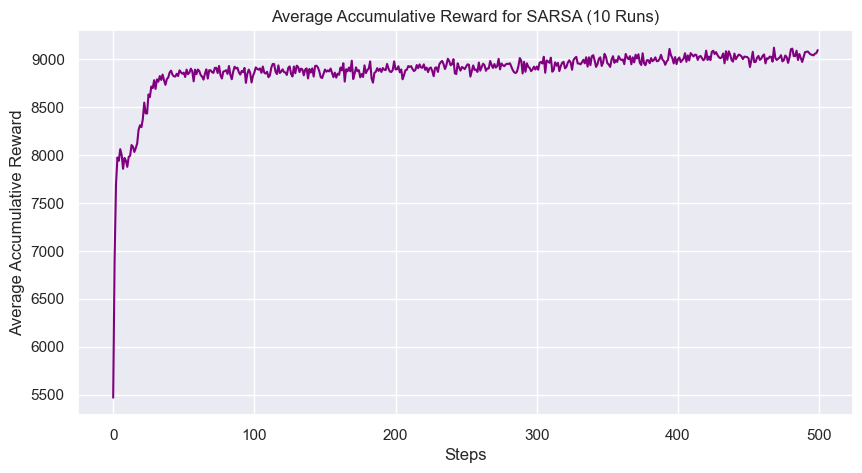

In [62]:

drawAverageAccumulativeReward(avg_reward_sarsa)
plt.title('Average Accumulative Reward for SARSA (10 Runs)')

# SARSA ( $\lambda$ )

In [38]:
def SARSA_LAMBDA(runs, episodes, steps, alpha, gamma, lamda):
    q = np.zeros((num_states,num_actions))
    E = np.zeros((num_states,num_actions))

    total_reward = np.zeros((runs,episodes))
    avg_reward = np.zeros((episodes))
        
    for n in range(runs):
        # Initialize Q table    
        q = np.zeros((num_states,num_actions))
        
        # SARSA Learning Algorithm
        for e in range(episodes):
            E = np.zeros((num_states,num_actions))

            # Select random state
            s = random.randint(0,num_states-1)

            step = 0
            episode_reward = 0

            # Select action based on epsilon greedy policy
            a = getAction(s,q)
            
            while step < steps:
                s_prime = getNextState(s,a,getNoise(prob))

                # Select action based on epsilon greedy policy
                a_prime = getAction(s_prime,q)

                delta = r[a][s][s_prime] + (gamma*q[s_prime][a_prime]) - q[s][a]

                E[s][a] = E[s][a] + 1

                for i in range(num_states):
                    for j in range(num_actions):
                        q[i][j] = q[i][j] + (alpha*delta*E[i][j])
                        E[i][j] = gamma*lamda*E[i][j]

                episode_reward += r[a][s][s_prime]
                
                # print(f'State: {s} Action: {a} Reward: {r[a][s][s_prime]} Next State: {s_prime} Next Action: {a_prime} Q: {q[s][a]}')
                s = s_prime
                a = a_prime

                step += 1
            
            total_reward[n][e] = episode_reward
        
        policy = generate_optimal_policy(q)
        print(f'Run: {n+1} - Policy: {policy}')

    avg_reward = total_reward.mean(axis=0)

    optimal_policy = generate_optimal_policy(q)

    return q, avg_reward, optimal_policy

q_sarsa_lambda, avg_reward_sarsa_lambda, optimal_policy = SARSA_LAMBDA(runs=num_runs, episodes=num_episodes, steps=num_steps, alpha=alpha, gamma=gamma, lamda=0.95)

print(f'\nOptimal Policy:')
print(optimal_policy)

Run: 1 - Policy: [3 4 3 4 3 4 4 2 2 3 3 4 4 2 2 1]
Run: 2 - Policy: [4 4 3 3 3 2 4 4 3 2 4 4 4 2 2 2]
Run: 3 - Policy: [3 4 3 4 4 3 3 2 4 4 3 3 4 4 2 1]
Run: 4 - Policy: [3 4 4 2 2 4 1 2 4 3 4 3 3 4 3 4]
Run: 5 - Policy: [2 4 4 1 2 2 2 2 3 4 2 4 4 1 3 1]
Run: 6 - Policy: [4 4 1 4 4 4 3 3 2 4 2 3 2 1 2 3]
Run: 7 - Policy: [2 2 4 4 3 2 4 2 2 3 3 2 3 2 3 1]
Run: 8 - Policy: [2 3 4 4 3 4 2 2 3 4 4 4 2 4 2 2]
Run: 9 - Policy: [3 2 3 4 4 2 2 2 4 2 4 3 2 4 4 1]
Run: 10 - Policy: [3 4 3 2 4 4 4 4 2 2 2 4 2 4 3 1]

Optimal Policy:
[3 4 3 2 4 4 4 4 2 2 2 4 2 4 3 1]


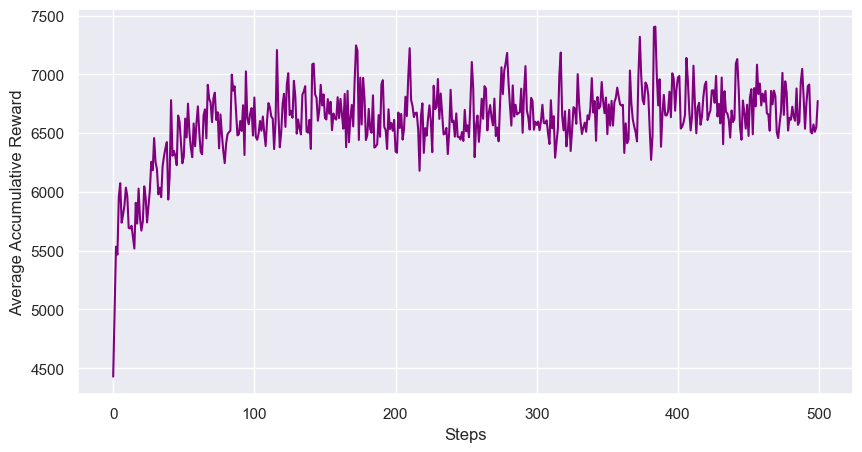

In [59]:
drawAverageAccumulativeReward(avg_reward_sarsa_lambda)

# Actor-Critic

In [40]:
h = np.zeros((num_states,num_actions))
v = np.zeros((num_states,num_actions))
pi = np.zeros((num_states, num_actions))

gamma = 0.95

beta = 0.05

def calculateSoftmax(h):
    # pi = np.zeros((num_states, num_actions))

    for s in range(num_states):
        for a in range(num_actions):
            # pi[s][a] = softmax(np.sum(np.exp(h[s])),h[s][a])
            pi[s][a] = np.exp(h[s][a]) / np.sum(np.exp(h[s][:]))
    
    return pi

# Method to get the action based on softmax policy
def getActionSoftmax(h,s):
    for a in range(num_actions):
        pi[s][a] = np.exp(h[s][a]) / np.sum(np.exp(h[s][:]))

    action = np.random.choice(num_actions, p=pi[s])

    return action, pi[s][action]

# Actor-Critic Learning Algorithm
def actor_critic(runs, episodes, steps, alpha, gamma, beta):    
    
    for n in range(runs):
        # Initializations    
        h = np.zeros((num_states,num_actions))
        v = np.zeros((num_states,num_actions))
        pi = np.zeros((num_states, num_actions))

        total_reward = np.zeros((runs,episodes))
        avg_reward = np.zeros((episodes))

        for e in range(episodes):
            # Select random state
            s = random.randint(0,num_states-1)

            step = 0
            episode_reward = 0
            while step < steps:
                # Select action based on softmax policy
                a, pi2 = getActionSoftmax(h,s)

                # Get the next state using the selected action a and noise
                s_prime = getNextState(s,a, getNoise(prob))

                # Calculate TD Error
                delta = r[a][s][s_prime] + (gamma*v[s_prime][a]) - v[s][a]
                episode_reward += r[a][s][s_prime]

                v[s][a] = v[s][a] + alpha*delta

                h[s][a] = h[s][a] + (beta*delta*(1-pi2))

                # print(f'States: {s} Action: {a}')
                # print(f'V(s): {v[s]} H(s): {h[s]}\n')

                s = s_prime

                step += 1
            
            total_reward[n][e]   = episode_reward
        
        policy = generate_optimal_policy(v)
        print(f'Run: {n+1} - Policy: {policy}')

    avg_reward = np.mean(total_reward, axis=0)

    optimal_policy = generate_optimal_policy(v)

    return v, avg_reward, optimal_policy

v_actor_critic, avg_reward_actor_critic, optimal_policy = actor_critic(runs=num_runs, episodes=num_episodes, steps=num_steps, alpha=alpha, gamma=gamma, beta=beta)

# drawOptimalPath(startState, terminalState, 'Maze Problem - Optimal Path From Start to Terminal', optimal_policy)


Run: 1 - Policy: [2 4 4 2 4 2 2 2 4 2 4 2 2 2 2 2]
Run: 2 - Policy: [2 3 3 2 2 2 2 2 2 2 2 2 3 2 2 2]
Run: 3 - Policy: [4 2 2 2 2 2 4 4 2 2 2 4 2 2 2 2]
Run: 4 - Policy: [2 2 2 4 4 4 4 4 2 4 4 4 4 4 4 4]
Run: 5 - Policy: [3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3]
Run: 6 - Policy: [4 4 4 4 3 4 3 4 4 4 3 4 3 4 4 4]
Run: 7 - Policy: [4 2 2 4 2 4 2 4 2 2 2 4 2 4 4 4]
Run: 8 - Policy: [2 4 4 4 2 4 4 4 2 4 4 4 4 4 4 4]
Run: 9 - Policy: [2 3 3 2 3 2 3 2 3 3 3 2 2 2 2 2]
Run: 10 - Policy: [4 3 4 4 4 3 3 4 3 4 4 4 4 4 4 4]


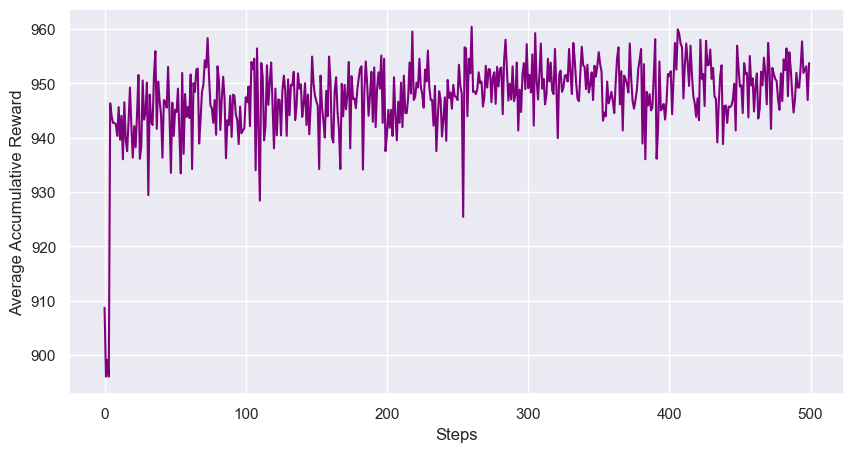

In [60]:
# print(avg_reward_actor_critic)
drawAverageAccumulativeReward(avg_reward_actor_critic)

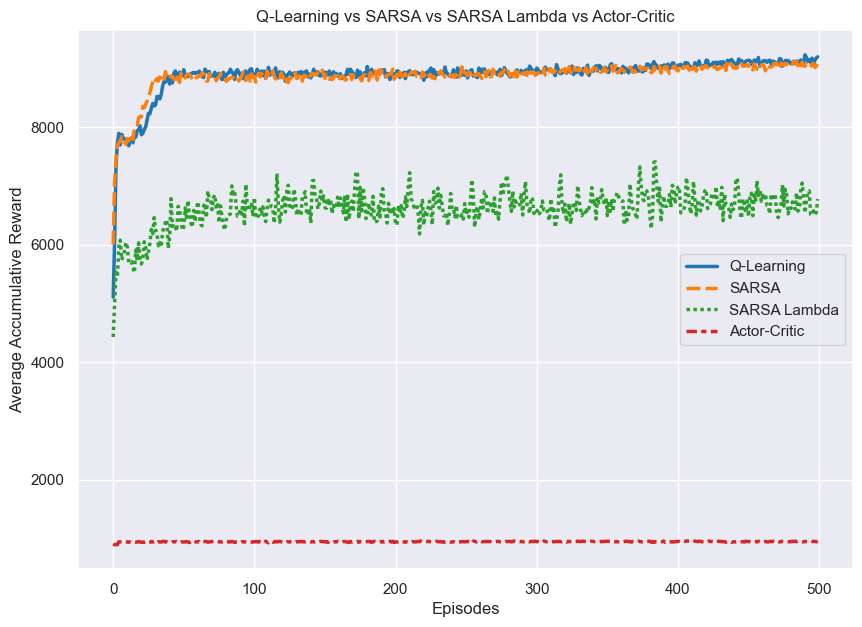

In [61]:
import pandas as pd
import seaborn as sns


data_preproc = pd.DataFrame({
    'Q-Learning': avg_reward_qlearning,
    'SARSA': avg_reward_sarsa,
    'SARSA Lambda': avg_reward_sarsa_lambda,
    'Actor-Critic': avg_reward_actor_critic})
    

fig = plt.subplots(figsize=(10, 7))
# sns.lineplot(data=avg_reward_qlearning, color='purple', alpha=0.8)
# sns.lineplot(data=avg_reward_sarsa, color='orange', alpha=0.8)
# sns.lineplot(data=[avg_reward_qlearning,avg_reward_sarsa,avg_reward_actor_critic]).set(title='Q-Learning vs SARSA vs Actor-Critic', xlabel='Episodes', ylabel='Average Accumulative Reward')
sns.lineplot(data=data_preproc, palette='tab10', linewidth=2.5).set(title='Q-Learning vs SARSA vs SARSA Lambda vs Actor-Critic', xlabel='Episodes', ylabel='Average Accumulative Reward')
sns.set_style("darkgrid")
# plt.legend(['Actor-Critic', 'Q-Learning', 'SARSA'], loc ="lower right")
plt.show()